In [ ]:
import os
spark_version = 'spark-3.0.2'
os.environ['spark-3.0.2']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:14 http://ppa.lau

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath").getOrCreate()

### Load Amazon Data into Spark DataFrame

In [ ]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   18069663|R3P2HIOQCIN5ZU|B000XB31C0|     265024781|Minnetonka Men's ...|           Shoes|          1|            0|          0|   N|                Y|                   .|Do not buy: reall...| 2015-08-31|
|         US|   16251825|R12VVR0WH5Q24V|B00CFYZH5W|     259035853|Teva Men's Pajaro...|           Shoes|          5|    

In [ ]:
#to check the datatypes in the dataframe
df.schema

StructType(List(StructField(marketplace,StringType,true),StructField(customer_id,IntegerType,true),StructField(review_id,StringType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(product_title,StringType,true),StructField(product_category,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true),StructField(review_headline,StringType,true),StructField(review_body,StringType,true),StructField(review_date,StringType,true)))

### Create DataFrames to match tables

In [ ]:
from pyspark.sql.functions import to_date
# Read in the Review dataset as a DataFrame
customer_clean_df = df.dropna()
customer_clean_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   18069663|R3P2HIOQCIN5ZU|B000XB31C0|     265024781|Minnetonka Men's ...|           Shoes|          1|            0|          0|   N|                Y|                   .|Do not buy: reall...| 2015-08-31|
|         US|   16251825|R12VVR0WH5Q24V|B00CFYZH5W|     259035853|Teva Men's Pajaro...|           Shoes|          5|    

In [ ]:
# Drop duplicates
customer_clean_1_df = customer_clean_df.drop_duplicates()
customer_clean_1_df.show(10)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   12731835|R1000E0AHJ5E1V|B00E9PFHPK|     257352271|Qupid Ponder-06 N...|           Shoes|          4|            0|          0|   N|                N|Adorable high qua...|These shoes are a...| 2013-10-04|
|         US|   12123247|R100A5CHCA9GMG|B00DZI79R6|     575104294|REFRESH CHERRY-02...|           Shoes|          1|    

In [ ]:
# Create the customers_table DataFrame
customers_df = customer_clean_df.groupby("customer_id").agg({"customer_id":"count"}).withColumnRenamed("count(customer_id)", "customer_count")
customers_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   16121565|             5|
|   48146680|             1|
|   11062912|             1|
|   51451778|             1|
|   27920838|             1|
+-----------+--------------+
only showing top 5 rows



In [ ]:
customers_df.schema

StructType(List(StructField(customer_id,IntegerType,true),StructField(customer_count,LongType,false)))

In [ ]:
# Create the products_table DataFrame and drop duplicates.
#df.filter("price<20").select("points","country","price").show(5)
products_df = customer_clean_df.select(["product_id","product_title"]).drop_duplicates()
products_df.show(20)

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B001CJL5ES|L.B. Evans Men's ...|
|B002MCVHUQ|New Balance Insol...|
|B00UXBFW6S|Kenox Sling Backp...|
|B002CMM4M6|Capezio Women's 1...|
|B00HNO32BU|Timberland PRO Me...|
|B00C6BQQW2|New Balance Men's...|
|B00M0NREE0|New Balance Women...|
|B00ZC4VIKK|Donalworld Women ...|
|B00291CGH8|Justin Boots Wome...|
|B000P6GKOO|Nike Men's Rosher...|
|B00IEB8BQ2|Khan New 2014 Uni...|
|B00IBGJKW4|Powerstep Ultrast...|
|B008KK1D5S|Clarks Women's Br...|
|B003IHV9XE|Birkenstock Women...|
|B00M9500FY|FitFlop Women's L...|
|B00R59ZBXU|Keds Women's Doub...|
|B00KQ66NBS|New Balance Men's...|
|B00E41QYRE|Jambu Women's Xte...|
|B0106QF79Q|Sanita Women's Pr...|
|B0084ZF7V0|DV by Dolce Vita ...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
products_df.schema

StructType(List(StructField(product_id,StringType,true),StructField(product_title,StringType,true)))

In [ ]:
# Create the review_id_table DataFrame.
# Convert the 'review_date' column to a date datatype with to_date("review_date", 'yyyy-MM-dd').alias("review_date")
review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
review_id_df.show(10)

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
|R3P2HIOQCIN5ZU|   18069663|B000XB31C0|     265024781| 2015-08-31|
|R12VVR0WH5Q24V|   16251825|B00CFYZH5W|     259035853| 2015-08-31|
| RNCCKB6TV5EEF|   20381037|B00S8JNN3Q|     666066660| 2015-08-31|
|R2NZXYIVCGB13W|     108364|B00XFBPOQG|     448483263| 2015-08-31|
|R2EQ1TG9IT3OEQ|   45449350|B00SW64Y9W|       7853171| 2015-08-31|
|R1WXA9JSC2H1U1|   19324665|B011F9E6LI|      14311457| 2015-08-31|
|R12ENYLFGGNWRV|   50073594|B00HAUP1OI|     264821602| 2015-08-31|
|R2R07E5PNXEUO5|   21706057|B00L1RKOKW|     767118055| 2015-08-31|
|R27BA52AKWMWN3|   13708216|B005WA9MSE|     813856438| 2015-08-31|
| RLF8DOID2KD5O|   40542649|B00BEYQI5C|     661491213| 2015-08-31|
+--------------+-----------+----------+--------------+-----------+
only showing top 10 rows



In [ ]:
review_id_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(customer_id,IntegerType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(review_date,DateType,true)))

In [ ]:
# Create the vine_table. DataFrame
vine_df = customer_clean_1_df.select(["review_id","star_rating","helpful_votes","total_votes","vine","verified_purchase"])
vine_df.show(20)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1000E0AHJ5E1V|          4|            0|          0|   N|                N|
|R100A5CHCA9GMG|          1|            2|          2|   N|                Y|
|R100A968SZR4GH|          5|            0|          0|   N|                Y|
|R100HVIG9VEABL|          5|            1|          1|   N|                N|
|R100ZMBT0DGFFH|          5|            8|         10|   N|                Y|
|R101BSLZ8K12T6|          5|            0|          1|   N|                Y|
|R101I5DOJAUSZ7|          4|            0|          0|   N|                Y|
|R101VVQ9LXBADV|          5|            1|          1|   N|                Y|
|R101VY19JHVABI|          4|            0|          0|   N|                N|
|R1026R3QQEM02Q|          5|            0|          0|   N|     

In [ ]:
vine_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#we need to convert the "star_rating" datatype into integer , since we have defined it as an integer in the "vine_table" we created in pgAdmin.
#review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
#data_df = data_df.withColumn("Plays", data_df["Plays"].cast(IntegerType()))
#customers_df = customers_df.withColumn("customer_count",col("customer_count").cast("int"))
vine1_df = vine_df.select(["review_id",vine_df["star_rating"].cast("int").alias("star_rating"),"helpful_votes","total_votes","vine","verified_purchase"])
vine1_df .show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1000E0AHJ5E1V|          4|            0|          0|   N|                N|
|R100A5CHCA9GMG|          1|            2|          2|   N|                Y|
|R100A968SZR4GH|          5|            0|          0|   N|                Y|
|R100HVIG9VEABL|          5|            1|          1|   N|                N|
|R100ZMBT0DGFFH|          5|            8|         10|   N|                Y|
|R101BSLZ8K12T6|          5|            0|          1|   N|                Y|
|R101I5DOJAUSZ7|          4|            0|          0|   N|                Y|
|R101VVQ9LXBADV|          5|            1|          1|   N|                Y|
|R101VY19JHVABI|          4|            0|          0|   N|                N|
|R1026R3QQEM02Q|          5|            0|          0|   N|     

In [ ]:
vine1_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

### Analysing the vine data

In [ ]:
# 1.Filter the Vine DataFrame by those that had 20+ total votes
df1 = vine1_df.filter(vine1_df["total_votes"] >= 20)
df1.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RFO47EUA8VO07|          1|          153|        165|   N|                Y|
|R1FY7QX8ZVKF3B|          2|           23|         27|   N|                Y|
|R1JQ6FVMNPTTGJ|          5|           58|         58|   N|                Y|
|R3TGDQWQ4IWBF4|          5|           18|         20|   N|                Y|
| RFIFX28ALACM4|          1|           49|         51|   N|                Y|
|R31YTDENNMDYLJ|          1|           40|         40|   N|                Y|
|R17UV33XE6IWTX|          1|           17|         22|   N|                Y|
| R701I3ZQH3MYJ|          5|           49|         51|   N|                Y|
|R2SWEEB6CUQ358|          3|           36|         37|   N|                Y|
|R320QZ1YWKW6KC|          4|           22|         24|   N|     

In [ ]:
#2.retrieve all the rows where the number of helpful_votes divided by total_votes is equal to or greater than 50%.
df2 = df1.filter(df1["helpful_votes"]/df1["total_votes"] >= 0.5)
df2.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RFO47EUA8VO07|          1|          153|        165|   N|                Y|
|R1FY7QX8ZVKF3B|          2|           23|         27|   N|                Y|
|R1JQ6FVMNPTTGJ|          5|           58|         58|   N|                Y|
|R3TGDQWQ4IWBF4|          5|           18|         20|   N|                Y|
| RFIFX28ALACM4|          1|           49|         51|   N|                Y|
|R31YTDENNMDYLJ|          1|           40|         40|   N|                Y|
|R17UV33XE6IWTX|          1|           17|         22|   N|                Y|
| R701I3ZQH3MYJ|          5|           49|         51|   N|                Y|
|R2SWEEB6CUQ358|          3|           36|         37|   N|                Y|
|R320QZ1YWKW6KC|          4|           22|         24|   N|     

In [ ]:
#3.Create a new DataFrame or table that retrieves all the rows where a review was written as part of the Vine program (paid), vine == 'Y'.
vine_yes3_df = df2.filter(df2["vine"] == "Y")
vine_yes3_df.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R37VCW6HA0Z72T|          5|           27|         28|   Y|                N|
|R1SPWJDHUWWC5E|          5|           88|         98|   Y|                N|
|R11XKHFS4KQS3Z|          4|          205|        211|   Y|                N|
|R3A7BQX1JDKOM5|          4|           20|         20|   Y|                N|
|R1307JMPUEQXOW|          5|           31|         35|   Y|                N|
|R3SEZS7BZEC69Y|          5|           16|         20|   Y|                N|
| R5OMLMK13A8NS|          5|           34|         38|   Y|                N|
| RBMDYE7LUH9FI|          5|           26|         32|   Y|                N|
|R1Y93KWKAX1P5N|          2|           26|         31|   Y|                N|
|R3KOK2SH39BZU1|          3|           94|         96|   Y|     

In [ ]:
#4.Create a new DataFrame and retrieve all the rows where the review was not part of the Vine program (unpaid), vine == 'N'.
vine_No4_df = df2.filter(df2["vine"] == "N")
vine_No4_df.show(10)


+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RFO47EUA8VO07|          1|          153|        165|   N|                Y|
|R1FY7QX8ZVKF3B|          2|           23|         27|   N|                Y|
|R1JQ6FVMNPTTGJ|          5|           58|         58|   N|                Y|
|R3TGDQWQ4IWBF4|          5|           18|         20|   N|                Y|
| RFIFX28ALACM4|          1|           49|         51|   N|                Y|
|R31YTDENNMDYLJ|          1|           40|         40|   N|                Y|
|R17UV33XE6IWTX|          1|           17|         22|   N|                Y|
| R701I3ZQH3MYJ|          5|           49|         51|   N|                Y|
|R2SWEEB6CUQ358|          3|           36|         37|   N|                Y|
|R320QZ1YWKW6KC|          4|           22|         24|   N|     

In [ ]:
vine_yes3_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5a.The number of 5-star reviews, and the percentage of 5-star reviews for the paid review vine == Y
Paid_five_star_number = vine_yes3_df[vine_yes3_df['star_rating']== 5].count()
Total_paid_number = vine_yes3_df.count()
Percentage_five_star_vine = float(Paid_five_star_number) / float(Total_paid_number)
print ("Total_paid_number:")
print(Total_paid_number)
print ("Paid_five_star_number:")
print(Paid_five_star_number)
print ("Percentage_five_star_vine:")
print(Percentage_five_star_vine)

Total_paid_number:
22
Paid_five_star_number:
13
Percentage_five_star_vine:
0.5909090909090909


In [ ]:
vine_No4_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5b.The number of 5-star reviews, and the percentage of 5-star reviews for the unpaid review vine == N
Unpaid_five_star_number = vine_No4_df[vine_No4_df['star_rating']== 5].count()
Total_Unpaid_number = vine_No4_df.count()
Percentage_five_star_vine_Unpaid = float(Unpaid_five_star_number) / float(Total_Unpaid_number)
print ("Total_Unpaid_number:")
print(Total_Unpaid_number)
print ("Unpaid_five_star_number:")
print(Unpaid_five_star_number)
print ("Percentage_five_star_vine_Unpaid:")
print(Percentage_five_star_vine_Unpaid)

Total_Unpaid_number:
26924
Unpaid_five_star_number:
14439
Percentage_five_star_vine_Unpaid:
0.5362873272916358


In [ ]:
import matplotlib.pyplot as plt,numpy as np

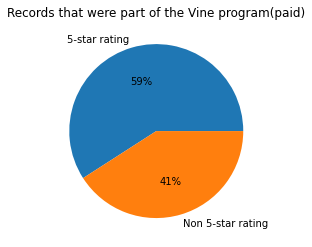

In [ ]:
p=np.array([Percentage_five_star_vine,1-Percentage_five_star_vine])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were part of the Vine program(paid)")
plt.show()

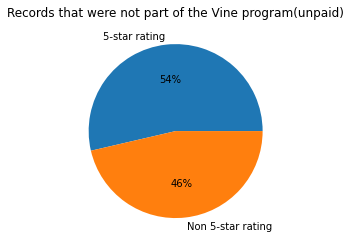

In [ ]:
p=np.array([Percentage_five_star_vine_Unpaid,1-Percentage_five_star_vine_Unpaid])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were not part of the Vine program(unpaid)")
plt.show()